# Visualizing COVID19 outbreak in India
Visualizing COVID19 outbreak in India using GeoPandas and Bokeh
### [Run this notebook in Google Colab](https://colab.research.google.com/github/MoadComputer/covid19-visualization/blob/master/examples/COVID19_India.ipynb)

## Install dependencies

In [0]:
%%capture
! python3 -m pip install fiona geopandas

## Import libraries

In [0]:
import os
import math
import json
import bokeh
import geopandas
import pandas as pd
import numpy as np

from bokeh.io.doc import curdoc
from bokeh.palettes import brewer
from bokeh.plotting import figure
from bokeh.plotting import show as plt_show
from bokeh.io import output_notebook, show, output_file
from bokeh.layouts import widgetbox, row, column, gridplot
from bokeh.tile_providers import Vendors, get_provider
from bokeh.models import Slider, HoverTool, Select, Div, Range1d, WMTSTileSource
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar, NumeralTickFormatter

## Load GeoJSON file of India

In [3]:
India_statewise = geopandas.read_file('https://github.com/MoadComputer/covid19-visualization/raw/master/data/GeoJSON_assets/India_statewise.geojson')
India_statewise.crs = {'init': 'epsg:4326'}
India_statewise.head()

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,state,geometry
0,Andaman and Nicobar Islands,"MULTIPOLYGON (((93.71976 7.20707, 93.71909 7.2..."
1,Andhra Pradesh,"MULTIPOLYGON (((81.39375 16.33380, 81.39224 16..."
2,Arunachal Pradesh,"POLYGON ((96.16261 29.38078, 96.16860 29.37432..."
3,Assam,"MULTIPOLYGON (((89.74323 26.30362, 89.74290 26..."
4,Bihar,"MULTIPOLYGON (((84.50720 24.26323, 84.50355 24..."


## Load COVID19 India data
The data is aggregated from the [Ministry of Health and Family Welfare, Government of India](https://www.mohfw.gov.in/#state-data) website

In [4]:
covid19_data = pd.read_csv('https://github.com/MoadComputer/covid19-visualization/raw/master/data/India_statewise/COVID19_India_statewise.csv')
covid19_data.head()

,ID,state,total_cases,discharged,deaths
0,1,Andhra Pradesh,226,1,3
1,2,Andaman and Nicobar Islands,10,0,0
2,3,Arunachal Pradesh,1,0,0
3,4,Assam,26,0,0
4,5,Bihar,30,0,1


## Display the list of states with no COVID19 reports

In [5]:
noCOVID19_list = list(set(list(India_statewise.state.values)) -set(list(covid19_data.state)))
print('A total of: {} states with no reports of COVID19 ...'.format(len(noCOVID19_list)))
print('\nStates in India with no COVID19 reports:')
for noCOVID19_state in noCOVID19_list:
  print('\n{} ...'.format(noCOVID19_state))

A total of: 7 states with no reports of COVID19 ...

States in India with no COVID19 reports:

Daman and Diu ...

Tripura ...

Sikkim ...

Dadara and Nagar Havelli ...

Lakshadweep ...

Meghalaya ...

Nagaland ...


## Combining geographical and COVID19 data

In [0]:
def covid19_json(covid_df, geo_df):
    merged_df = pd.merge(geo_df, covid_df, on='state', how='left')
    merged_df = merged_df.fillna(0)
    merged_json = json.loads(merged_df.to_json())
    json_data = json.dumps(merged_json)
    return {'json_data': json_data, 'data_frame': merged_df}

In [0]:
merged_data = covid19_json(covid19_data, India_statewise)
merged_json = merged_data['json_data']

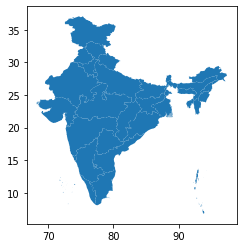

In [8]:
merged_data['data_frame'].plot()

In [0]:
def make_covid19_plot(covid19_geosource, 
                      input_df=None,
                      input_field=None,
                      plot_title=None):
  palette = brewer['Reds'][8]
  palette = palette[::-1]
  hover = HoverTool(tooltips = [ ('State','@state'),
                                ('Total cases', '@total_cases'),
                                ('Total discharged/migrated', '@discharged'),
                                ('Total deaths', '@deaths')])
  color_mapper = LinearColorMapper(palette = palette, 
                                   low = 0, 
                                   high = int(10*(np.ceil(np.max(input_df[input_field].values)/10))))
  format_tick = NumeralTickFormatter(format=str(input_df[input_field].values))
  color_bar = ColorBar(color_mapper=color_mapper, 
                       label_standoff=10, 
                       formatter=format_tick,
                       border_line_color=None, 
                       location = (0, 0))
  plt = figure(title = plot_title,
               tools='save', 
               plot_height = 500, plot_width = 550,
               toolbar_location = 'left'
               #lod_factor=int(1e7),
               #lod_threshold=int(2),
               #output_backend="webgl"
             )
  plt.xgrid.grid_line_color = None
  plt.ygrid.grid_line_color = None
  plt.axis.visible = False
  plt.patches('xs','ys', 
            source = covid19_geosource, 
            fill_color = {'field' : 'deaths', 
                          'transform' : color_mapper},
            line_color = 'grey', 
            line_width = 0.25, 
            fill_alpha = 1)
  plt.add_layout(color_bar, 'right')
  plt.add_tools(hover)
  return plt

## Generate COVID19 plot

In [0]:
covid19_geosource=GeoJSONDataSource(geojson=merged_json)

plot_title='COVID-19 outbreak in India'

covid19_plot = make_covid19_plot(covid19_geosource, 
                                 input_df=covid19_data,
                                 input_field='deaths',
                                 plot_title=plot_title)

covid19_layout = column(covid19_plot)
curdoc().add_root(covid19_layout)

## Display the interactive COVID19 map for India
This will generate an interactive COVID19 outbreak map for India, within the notebook.
![Bokeh static output](https://github.com/MoadComputer/covid19-visualization/raw/master/examples/COVID19_India_Bokeh_output_20200406_131941.png)

In [0]:
output_notebook()
show(covid19_plot)

## View [hosted version of the app via Heroku](https://covid19india-visualization.herokuapp.com/COVID19_India)

In [12]:
import IPython
URL = 'https://covid19india-visualization.herokuapp.com/COVID19_India'
FRAME_WIDTH=600
FRAME_HEIGHT=550
iframe = '<iframe src={} width={} height={}></iframe>'.format(URL, 
                                                             FRAME_WIDTH, 
                                                             FRAME_HEIGHT)
IPython.display.HTML(iframe)